In [2]:
import dataCleaning
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import Webscraping.ReadCsv as read_csv
import Webscraping.reduce_data as reduce_data
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import to_categorical

from keras.layers import Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization

import tensorflow as tf
import random as rn 

from tqdm import tqdm

2023-05-22 18:24:36.666317: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-22 18:24:37.029754: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.10/site-packages/cv2/../../lib64:
2023-05-22 18:24:37.029806: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-22 18:24:37.935824: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnv

In [3]:
##Load data set
data_imgs = np.load('data/kkanj-imgs.npz')
data_labels = np.load('data/kkanji-labels.npz')

imgs = data_imgs['arr_0']
labels = data_labels['arr_0']
print(len(labels))

140424


In [23]:
##Clean using the data found when webscrapping.

dict_data= read_csv.add_nonocurring_kanjis("Webscraping/kanji_freq.csv");

print("amount of kanji before cleaning " + len(dict_data).__str__())


##Remove 50 precent of the data, apparently 50% of characters of some characters
dict_data = reduce_data.filter_dict_percentile(dict_data,50)

print("amount of kanji after cleaning " + len(dict_data).__str__())

mask = [key in dict_data for key in labels]  # Create a mask based on the presence of keys in the dictionary

print("amount of data before cleaning " + len(labels).__str__())
imgs = [imgs[i] for i, include in enumerate(mask) if include]  # Apply the mask to array x
labels = [labels[i] for i, include in enumerate(mask) if include]  # Apply the mask to array y

print("amount of data after cleaning " + len(labels).__str__())

amount of kanji before cleaning 3832
amount of kanji after cleaning 1947
amount of data before cleaning 140424
amount of data after cleaning 121568


In [ ]:
def kanji(kaniUnicode):
    return chr(int(kaniUnicode[2:], 16))

filtered_labels, filtered_imgs = dataCleaning.remove_min_occurences(labels, imgs)
filtered_labels, filtered_imgs = dataCleaning.remove_by_contours2(filtered_labels, filtered_imgs)

print(filtered_labels)
print(filtered_imgs)

X = filtered_imgs
Z = filtered_labels


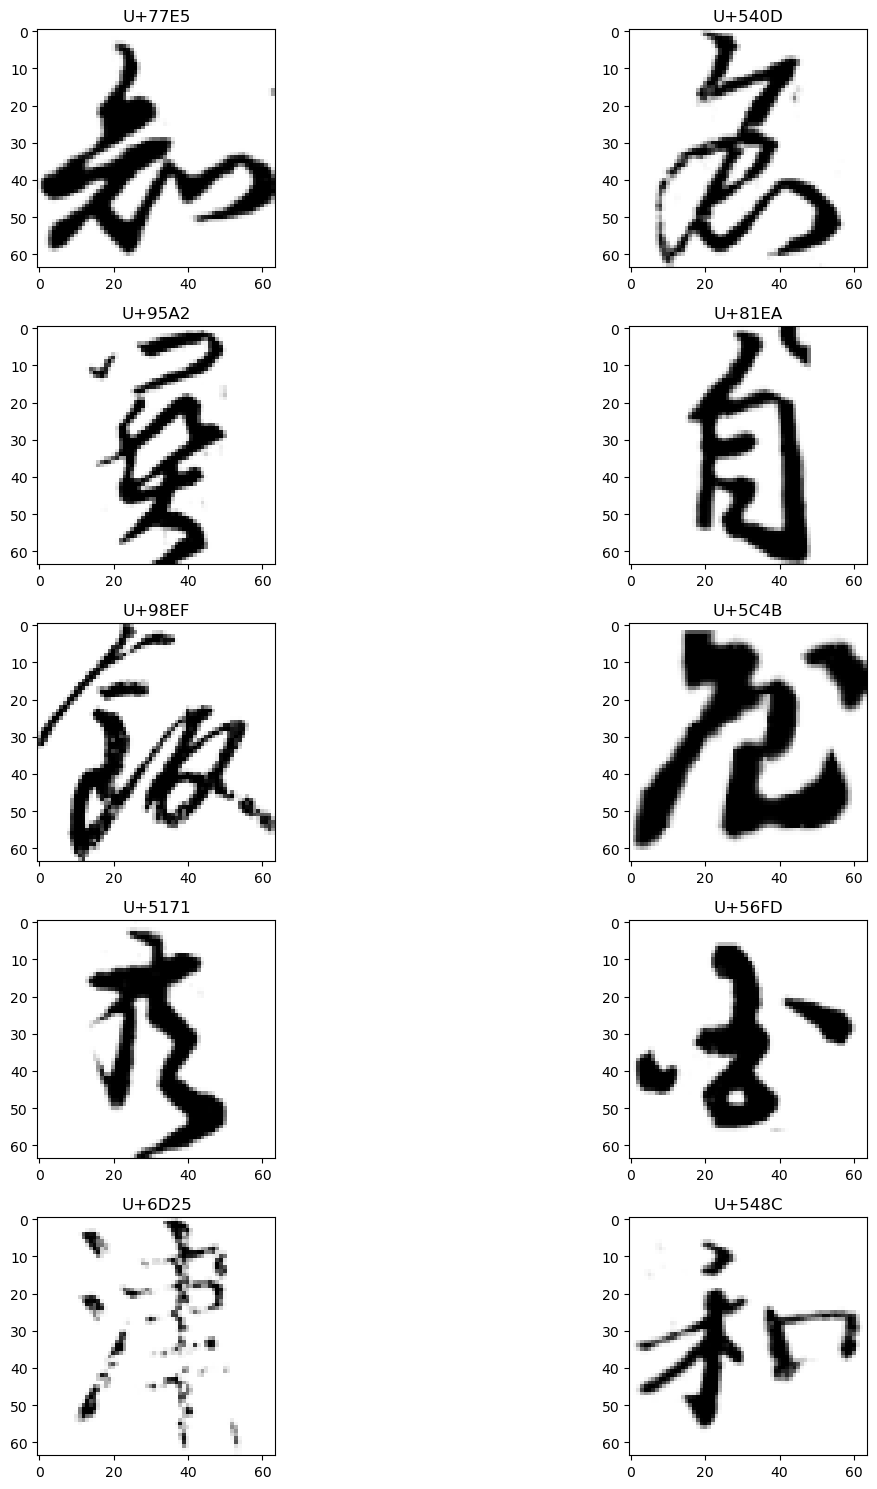

In [3]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range(2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l], cmap='Greys')
        ax[i,j].set_title(Z[l])
        
        
plt.tight_layout()

In [4]:
len(np.unique(Z))

306

In [5]:
le=LabelEncoder()


Y=le.fit_transform(Z)


Y=to_categorical(Y,len(np.unique(Z)))


X=np.array(X)


X=X/255


In [6]:
x_train,x_test,y_train,y_test = train_test_split(X,Y, test_size=0.25, random_state=42)
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

In [7]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size= (3,3), padding= 'Same', activation='relu', input_shape = (64,64, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size= (3,3), padding= 'Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 96, kernel_size= (1,1), padding= 'Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 96, kernel_size= (1,1), padding= 'Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(len(np.unique(Z)), activation="softmax"))

2023-05-17 12:50:50.150994: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.10/site-packages/cv2/../../lib64:
2023-05-17 12:50:50.152647: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-17 12:50:50.153300: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (3b04bf1cb71e): /proc/driver/nvidia/version does not exist
2023-05-17 12:50:50.165472: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appr

In [8]:
batch_size=200
epochs=3

from keras.callbacks import ReduceLROnPlateau
red_lr = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1,factor=0.1)

In [9]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range=0,
    width_shift_range=0,
    height_shift_range=0,
    horizontal_flip=False,
    vertical_flip=False
)

#datagen.fit(x_train.reshape(10500, 64, 64, 1))

In [10]:
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 96)        6240      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 96)         0

In [12]:
History = model.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test,y_test), verbose=1, steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/3
30/30 [==============================] - 9s 231ms/step - loss: 4.8149 - accuracy: 0.1795 - val_loss: 3.0584 - val_accuracy: 0.4312
Epoch 2/3
30/30 [==============================] - 6s 217ms/step - loss: 1.3071 - accuracy: 0.7807 - val_loss: 0.3348 - val_accuracy: 0.9459
Epoch 3/3
30/30 [==============================] - 6s 208ms/step - loss: 0.1337 - accuracy: 0.9800 - val_loss: 0.0548 - val_accuracy: 0.9930


INFO:tensorflow:Assets written to: ../Kanji-recognizer/saved_sequential_model/assets


INFO:tensorflow:Assets written to: ../Kanji-recognizer/saved_sequential_model/assets


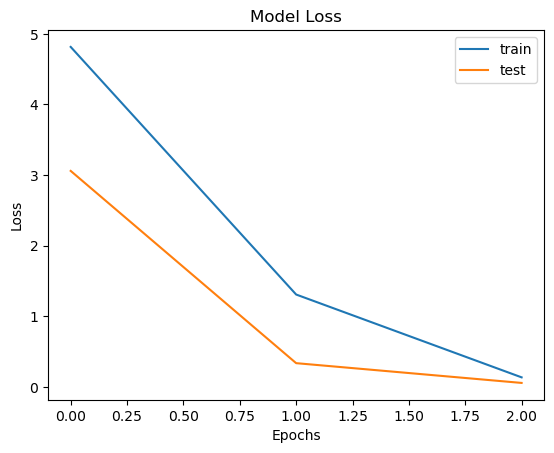

In [13]:
model.save('../Kanji-recognizer/saved_sequential_model')
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()